## Decode Linear Page Address to Page, Block, Plane Index

In [1]:
def decode_page_address(page_address: int, pages_per_block: int, planes: int) -> tuple[int, int, int]:
    """
    Decode a linear page address into (page, block, plane_index)
    
    :param page_address:     The straight page address.
    :param pages_per_block:  Number of pages in each block.
    :param planes:           Number of planes (1, 2, 4, ...).
    
    :return: (page, block, plane_index)
    """
    # 1) Extract 'page' within a block:
    page = page_address % pages_per_block
    
    # 2) Remove 'page' bits to get the combined block/plane field:
    block_plane_field = page_address // pages_per_block
    
    # 3) Extract 'plane_index' from the lower bits:
    #    plane_index = (block_plane_field mod planes) 
    #    because if planes=2 => 1 bit; if planes=4 => 2 bits, etc.
    plane_index = block_plane_field % planes
    
    # 4) "pure block" index :
    block = block_plane_field
    
    #    If you prefer to keep plane bits inside 'block', then do:
    # block = block_plane_field
    
    return (page, block, plane_index)

## Build Address (5 or 3 Cycles)

In [2]:
def build_5_cycle_address(column: int, page: int, block: int, plane: int, lun: int) -> list[int]:
    """
    Build 5 address cycles (bytes) according to the layout:
    1) Column address (16 bits):
       - Cycle 1 => column[7..0]
       - Cycle 2 => column[15..8]
    2) Page address (10 bits total):
       - Cycle 3 => page[7..0]        (lowest 8 bits)
       - Cycle 4 => page[9..8]       (bits [1..0])
    3) Plane (2 bits), embedded in BA[11..10]:
       - Cycle 4 bits [3..2] => plane[1..0]
    4) Block address (10 bits), combined with plane bits => total 12 bits:
       - Cycle 4 bits [7..4] => block[3..0]   (changed as requested)
       - Cycle 5 bits [5..0] => block[9..4]   (changed as requested)
    5) LUN (1 bit):
       - Cycle 5 bit [6] => lun
    :param column: up to 16 bits (0..65535)
    :param page:   up to 10 bits (0..1023)
    :param block:  up to 10 bits (0..1023) – plane bits separate
    :param plane:  0..3 (2 bits)
    :param lun:    0..1 (1 bit)
    :return: List of 5 bytes [cycle1..cycle5].
    """

    # ---------------------
    # Cycle 1 => lower 8 bits of column
    # Cycle 2 => upper 8 bits of column
    # ---------------------
    c1 = column & 0xFF
    c2 = (column >> 8) & 0xFF
    
    # ---------------------
    # Cycle 3 => lower 8 bits of page: page[7..0]
    # ---------------------
    c3 = page & 0xFF
    
    # ---------------------
    # Cycle 4 => c4[7..0]:
    #   bits[7..4] -> block[3..0] 
    #   bits[3..2] -> plane[1..0]
    #   bits[1..0] -> page[9..8]
    # ---------------------
    c4 = 0
    # block[3..0] => lower 4 bits of block
    c4 |= (block & 0xF) << 4
    # plane => 2 bits in [3..2]
    c4 |= (plane & 0x3) << 2
    # top 2 bits of page => page[9..8]
    c4 |= (page >> 8) & 0x3
    
    
    # ---------------------
    # Cycle 5 => c5[7..0]:
    #   bits[5..0] -> block[9..4]
    #   bit [6]    -> lun
    #   bit [7]    -> 0
    # ---------------------
    c5 = 0
    # block[9..4] => 6 bits
    c5 |= ((block >> 4) & 0x3F)
    # lun => bit [6]
    c5 |= ((lun & 0x1) << 6)
    
    return [c1, c2, c3, c4, c5]

In [3]:
def build_3_cycle_address(page: int, block: int, plane: int, lun: int) -> list[int]:
    
    # ---------------------
    # Cycle 1 => lower 8 bits of page: page[7..0]
    # ---------------------
    c1 = page & 0xFF
    
    # ---------------------
    # Cycle 2 => c4[7..0]:
    #   bits[7..4] -> block[3..0] 
    #   bits[3..2] -> plane[1..0]
    #   bits[1..0] -> page[9..8]
    # ---------------------
    c2 = 0
    # block[3..0] => lower 4 bits of block
    c2 |= (block & 0xF) << 4
    # plane => 2 bits in [3..2]
    c2 |= (plane & 0x3) << 2
    # top 2 bits of page => page[9..8]
    c2 |= (page >> 8) & 0x3
    
    
    # ---------------------
    # Cycle 3 => c5[7..0]:
    #   bits[5..0] -> block[9..4]
    #   bit [6]    -> lun
    #   bit [7]    -> 0
    # ---------------------
    c3 = 0
    # block[9..4] => 6 bits
    c3 |= ((block >> 4) & 0x3F)
    # lun => bit [6]
    c3 |= ((lun & 0x1) << 6)
    
    return [c1, c2, c3]

## Commands for Nand Flash and FTDI

In [4]:
#FTDI Commands
ACTIVATE_COMMNAD_LATCH = 0x40
ACTIVATE_ADDRESS_LATCH = 0x80
ACTIVATE_WRITE_PROTECT = 0x20
DEACTIVATE_CA_LATCH = 0x00

#Nand Flash Commands
NAND_CMD_READ_CYCLE1 = 0x00
NAND_CMD_READ_CYCLE2 = 0x30

NAND_CMD_PROGRAM_CYCLE1 = 0x80
NAND_CMD_PROGRAM_CYCLE2 = 0x10

NAND_CMD_BLOCK_ERASE_CYCLE1 = 0x60
NAND_CMD_BLOCK_ERASE_CYCLE2 = 0xD0

NAND_CMD_RESET = 0xFF
NAND_CMD_READ_STATUS = 0x70

WR_ADDRESS_CYCLE = 5
ERASE_ADDRESS_CYCLE = 3

## Nand Read Page Functions

In [5]:
def read_nand_command (cycle):
    #Command Cycle 1
    cmds1 = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0] 
    cmds1 += [NAND_CMD_READ_CYCLE1]
    ftdi.write_data(Array('B', cmds1))
    
    #Address Cycle 5 Consequtive
    cmds2 = [Ftdi.WRITE_EXTENDED, ACTIVATE_ADDRESS_LATCH, 0 , cycle[0]]
    for i in range(1,WR_ADDRESS_CYCLE,1):
        cmds2 += [Ftdi.WRITE_SHORT, 0, cycle[i]]
    ftdi.write_data(Array('B', cmds2))
    
    #Command Cycle 2
    cmds3 = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0]
    cmds3 += [NAND_CMD_READ_CYCLE2]
    ftdi.write_data(Array('B', cmds3))
    
    
    #print(f"Command 1:  {cmds1}")
    #print(f"Command 2:  {cmds2}")
    #print(f"Command 3:  {cmds3}")

In [6]:
def read_nand_page_bytes(read_len):
    cmds = []
    
    #Data Read Cycle
    cmds += [ftdi.READ_EXTENDED, DEACTIVATE_CA_LATCH , 0]
    
    for i in range(1, read_len, 1):
        cmds += [Ftdi.READ_SHORT, 0]
        
    cmds.append(Ftdi.SEND_IMMEDIATE)
    ftdi.write_data(Array('B', cmds))
    data = ftdi.read_data_bytes(read_len)
    return bytes(data)

## NAND Write Page Functions

In [7]:
def program_nand_page(cycle, data):
    #Command Cycle 1
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds1 = [Ftdi.WRITE_EXTENDED, activateCMD, 0] 
    cmds1 += [NAND_CMD_PROGRAM_CYCLE1]
    
    #Address Cycle 5 Consequtive
    activateADR = ACTIVATE_WRITE_PROTECT | ACTIVATE_ADDRESS_LATCH
    cmds2 = [Ftdi.WRITE_EXTENDED, activateADR, 0 , cycle[0]]
    for i in range(1,WR_ADDRESS_CYCLE,1):
        cmds2 += [Ftdi.WRITE_SHORT, 0, cycle[i]]
    
    #data cycle 
    activateDTC = ACTIVATE_WRITE_PROTECT | DEACTIVATE_CA_LATCH
    cmds3 = [Ftdi.WRITE_EXTENDED, activateDTC , 0, data[0]]
    for i in range(1,len(data),1):
        cmds3 += [Ftdi.WRITE_SHORT, 0, data[i]]
    
    #Command Cycle 2
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds4 = [Ftdi.WRITE_EXTENDED, activateCMD, 0]
    cmds4 += [NAND_CMD_PROGRAM_CYCLE2]
    
    #print(f"Command 1:  {cmds1}")
    #print(f"Command 2:  {cmds2}")
    #print(f"Command 3:  {cmds3}")
    #print(f"Command 4:  {cmds4}")
    
    ftdi.write_data(Array('B', cmds1))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds2))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds3))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds4))
    time.sleep(0.01)

In [8]:
def status_register_check():
    #Staus Cycle
    cmds1 = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0]
    cmds1 += [NAND_CMD_READ_STATUS]
    ftdi.write_data(Array('B', cmds1))
    #print(f"Command 5:  {cmds1}")
        
    cmds1 = [ftdi.READ_EXTENDED, DEACTIVATE_CA_LATCH , 0]
    cmds1 += [Ftdi.READ_SHORT, 0]
        
    cmds1.append(Ftdi.SEND_IMMEDIATE)
    ftdi.write_data(Array('B', cmds1))
    
    status = ftdi.read_data_bytes(1)
    state = ord(status)
    
    print(f"Status:{state:08b}")
    if state == 96:
        print("Successfully Done!!")
    else:
        print("failed, check the status byte")

In [9]:
def createDataStream(sizeDataArray):
    dataStream = []
    data = 0
    for i in range(0, sizeDataArray, 1):
        data += 1
        dataStream.append(data)
        if (data >= 8):
            data = 0
    print(len(dataStream))
    return dataStream

In [10]:
def createDataStreamZeros(sizeZerosArray):
    dataStream = []
    for i in range(0, sizeZerosArray, 1):
        dataStream.append(0)
    #print(len(dataStream))
    #print(dataStream)
    return dataStream

In [11]:
def createCharacterStream(sizechrArray):
    chrStream = ""
    data = 0
    for i in range(0, sizechrArray, 1):
        data = "A"
        chrStream += data
    print(len(chrStream))
    print(chrStream)
    return chrStream

## NAND Erase Block Functions

In [12]:
def erase_nand_block (cycle):
    #Command Cycle 1
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds1 = [Ftdi.WRITE_EXTENDED, activateCMD, 0] 
    cmds1 += [NAND_CMD_BLOCK_ERASE_CYCLE1]
    
    #Address Cycle 3 Consequtive
    activateADR = ACTIVATE_WRITE_PROTECT | ACTIVATE_ADDRESS_LATCH
    cmds2 = [Ftdi.WRITE_EXTENDED, activateADR, 0 , cycle[0]]
    for i in range(1,ERASE_ADDRESS_CYCLE,1):
        cmds2 += [Ftdi.WRITE_SHORT, 0, cycle[i]]
    
    #Command Cycle 2
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds3 = [Ftdi.WRITE_EXTENDED, activateCMD, 0]
    cmds3 += [NAND_CMD_BLOCK_ERASE_CYCLE2]
    
    print(f"Command 1:  {cmds1}")
    print(f"Command 2:  {cmds2}")
    print(f"Command 4:  {cmds3}")
    
    ftdi.write_data(Array('B', cmds1))
    ftdi.write_data(Array('B', cmds2))
    ftdi.write_data(Array('B', cmds3))
    time.sleep(1)

## FTDI Initialization

In [13]:
#essential functions
import usb.core
import usb.util
import time
from array import array as Array
from pyftdi.ftdi import *

In [14]:
#essential functions
VENDOR_ID = 0x0403
PRODUCT_ID = 0x6010

# direction_mask: 1 means output, 0 means input
# value_mask:     1 sets the pin high, 0 sets it low
DIRECTION_MASK = 0xFF  # all upper 8 bits as output
VALUE_MASK = 0x00     # pattern to set the pins to

# Initialize FTDI
#Creates an instance or object of the Ftdi class and stored in the ftdi variable
ftdi = Ftdi()

#Open a new interface to the specified FTDI device.
#open() method establishes a connection to a specific FTDI device.
ftdi.open(VENDOR_ID, PRODUCT_ID, interface=1)

#Configures the FTDI device into MCU Host Bus Emulation mode
ftdi.set_bitmode(0x00, Ftdi.BitMode.MCU)  # MCU = 0x08 (MCU Host Bus Emulation mode)

#Disable the “divide-by-5” clock prescaler allows higher frequency operation
ftdi.write_data(Array('B', [Ftdi.DISABLE_CLK_DIV5]))

#the FTDI device waits (in milliseconds) 
#before sending any partially filled USB packet up to the host if the buffer is not yet full.
ftdi.set_latency_timer(2)


# This tells the FTDI chip to set upper 8 bits with these direction and value settings
ftdi.write_data(bytes([
    Ftdi.SET_BITS_HIGH,
    VALUE_MASK,
    DIRECTION_MASK
]))

#Any pending outbound data in the transmit buffer is cleared
ftdi.purge_buffers()

#Reset the the nand flash chip
cmdsRST = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0, NAND_CMD_RESET]
print (cmdsRST)
ftdi.write_data(Array('B', cmdsRST))

[147, 64, 0, 255]


4

# MAIN CODE: Read, Write, Erase Operations of Nand Flash Memory

## Read Page Byte by Byte

In [21]:
#convert linear page address
linearPageAddress = 121
pagesPerBlock = 1024
NumberOfPlane = 4

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)

print(f"Address {linearPageAddress} => Page {pageX}, Block {blockX}, Plane {planeX}")

Address 121 => Page 121, Block 0, Plane 0


In [22]:
#create address cycle
column = 0
page   = pageX
block  = blockX
plane  = planeX
lun    = 0

#create 5 address cycle
cycles = build_5_cycle_address(column, page, block, plane, lun)
print(f"Address Cycles: {cycles}")

print("5 Address Cycles:")
for i, val in enumerate(cycles, start=1):
    print(f" Cycle {i}: 0x{val:02X}  (bin: {val:08b})")


Address Cycles: [0, 0, 121, 0, 0]
5 Address Cycles:
 Cycle 1: 0x00  (bin: 00000000)
 Cycle 2: 0x00  (bin: 00000000)
 Cycle 3: 0x79  (bin: 01111001)
 Cycle 4: 0x00  (bin: 00000000)
 Cycle 5: 0x00  (bin: 00000000)


In [23]:
byteLength = 1000

#Send the command and address cycles before page read
read_nand_command(cycles)

#Read byte by byte from Data Register
read_nand_page_bytes(byteLength)

b'\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x

## Program Pages in a Block

In [24]:
linearPageAddress = 121
pagesPerBlock = 1024
NumberOfPlane = 4

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)
addressCycleStream = build_5_cycle_address(0, pageX, blockX, planeX, 0)

In [25]:
pageBytes = 16384
data = createDataStream(pageBytes)

program_nand_page (addressCycleStream, data)

status_register_check()

16384
Status:01100000
Successfully Done!!


In [26]:
ftdi.purge_buffers()
read_nand_command(addressCycleStream)
read_nand_page_bytes(100)

b'\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04\x05\x06\x07\x08\x01\x02\x03\x04'

## Erase a Block

In [27]:
linearPageAddress = 121
pagesPerBlock = 1024
NumberOfPlane = 4

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)
print(f"Address {linearPageAddress} => Page {pageX}, Block {blockX}, Plane {planeX}")

blockEraseAddress = build_3_cycle_address(pageX, blockX, planeX, 0)

print("3 Address Cycles:")
for i, val in enumerate(blockEraseAddress, start=1):
    print(f" Cycle {i}: 0x{val:02X}  (bin: {val:08b})")

Address 121 => Page 121, Block 0, Plane 0
3 Address Cycles:
 Cycle 1: 0x79  (bin: 01111001)
 Cycle 2: 0x00  (bin: 00000000)
 Cycle 3: 0x00  (bin: 00000000)


In [28]:
erase_nand_block (blockEraseAddress)

status_register_check()

Command 1:  [147, 96, 0, 96]
Command 2:  [147, 160, 0, 121, 146, 0, 0, 146, 0, 0]
Command 4:  [147, 96, 0, 208]
Status:01100000
Successfully Done!!


In [29]:
ftdi.purge_buffers()
read_nand_command(addressCycleStream)
read_nand_page_bytes(100)

b'\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff'

In [24]:
#ftdi.close();

## Program a block

In [30]:
pagePerBlock = 1024
pageno = 0
blockno = 0
planeno = 0
pageBytes = 16384
for i in range(0, pagePerBlock, 1):
    pageno = i
    addressCycleStream = build_5_cycle_address(0, pageno, blockno, planeno, 0)
    data = createDataStreamZeros(pageBytes)
    program_nand_page (addressCycleStream, data)
status_register_check()

Status:01100000
Successfully Done!!


In [31]:
def nand_read_full_page(pageno, blockno):
    PagePerBlock = 1024
    planeno = 0
    pageBytes = 16384
    max_rx_buffer = 4096
    readData = bytes()
    ftdi.purge_buffers()

    addressCycleStream = build_5_cycle_address(0, pageno, blockno, planeno, 0)
    read_nand_command(addressCycleStream)

    for i in range(0, pageBytes//max_rx_buffer, 1):
        readData += read_nand_page_bytes(max_rx_buffer)
    readData += read_nand_page_bytes(pageBytes%max_rx_buffer)

    #Check the Programmed Page
    #print(len(readData))
    #print(type(readData))

    #for i in range(1, 16384, 1):
        #print(readData[i], end=" ")

    return readData

In [33]:
#nand_read_full_page(102, 0)

## Failure Bit Count

In [ ]:
def count_failed_byte_count(start_page, end_page, byte_to_write, fd):
    """
    Count the Failed Bit Count (FBC) from start_page to end_page
    and write the results to the provided file descriptor (fd).
    """

    page_per_block = 1024
    current_block = start_page // page_per_block
    fd.write(f"Block = {current_block}\n")
    pageFBC1 = []
    pageFBC2 = []
    pageFBC3 = []
    pageFBC4 = []

    block_fbc_count = 0
    page_data = bytes()
    # Read each page in the specified range
    for page_index in range(start_page, end_page):
        # Read data for the current page
        page_data = nand_read_full_page(page_index, current_block)
        
        # Count non-zero bytes
        page_fbc_count = sum(1 for b in page_data if b != 0)
        if (page_fbc_count == 1):
            pageFBC1 += [ page_index ]
        elif (page_fbc_count == 2):
            pageFBC2 += [ page_index ]
        elif (page_fbc_count == 3):
            pageFBC3 += [ page_index ]
        elif (page_fbc_count == 4):
            pageFBC3 += [ page_index ]

        # Write page-level FBC and raw data
        fd.write(f"Page = {page_index}, FBC = {page_fbc_count}, ")
        fd.write(",".join(str(b) for b in page_data))
        fd.write("\n")

        block_fbc_count += page_fbc_count

        # Check if we've crossed into a new block
        new_block = page_index // page_per_block
        if new_block != current_block:
            # Reset for the new block
            block_fbc_count = page_fbc_count
            current_block = new_block
    #print(len(page_data))
    #print(page_data)
    print("FBC Process Completed")
    print ("FBC1:", end=" ")
    print (pageFBC1)
    print ("FBC2:", end=" ")
    print (pageFBC2)
    print ("FBC3:", end=" ")
    print (pageFBC3)
    print ("FBC4:", end=" ")
    print (pageFBC4)

In [ ]:
# Specify your desired start and end pages
start_page = 0
end_page = 1024

# This is just a dummy value for 'byte_to_write'—you can set this as needed
byte_to_write = 0

# Open a file for logging
with open("CHECK_FBC_MLC_1.txt", "w") as fd:
    # Call the method, passing in your parameters and file descriptor
    count_failed_byte_count(start_page, end_page, byte_to_write, fd)

print("Done. Check 'CHECK_FBC_MLC_1.txt' for results.")

FBC Process Completed
FBC1: [48, 49, 52, 54, 55, 70, 81, 84, 86, 92, 94, 98, 112, 116, 118, 119, 120, 122, 126, 127, 135, 137, 148, 152, 153, 157, 158, 159, 166, 172, 198, 202, 204, 205, 206, 216, 220, 237, 238, 250, 288, 290, 302, 310, 316, 324, 330, 336, 346, 348, 350, 355, 364, 378, 384, 394, 404, 411, 418, 421, 428, 431, 434, 435, 451, 452, 454, 456, 466, 472, 476, 480, 481, 482, 490, 494, 496, 500, 501, 504, 516, 522, 528, 529, 536, 546, 558, 563, 568, 576, 579, 584, 586, 594, 600, 602, 603, 606, 612, 614, 620, 623, 647, 652, 659, 660, 663, 664, 678, 684, 694, 699, 700, 712, 720, 728, 730, 735, 737, 742, 750, 751, 754, 756, 757, 758, 762, 780, 782, 792, 799, 808, 812, 814, 816, 818, 819, 826, 830, 836, 838, 840, 854, 864, 866, 868, 870, 871, 872, 874, 890, 912, 914, 918, 924, 931, 938, 940, 944, 950, 951, 952, 956, 968, 970, 972, 974, 976, 980, 984, 986, 992, 995, 996, 1000, 1006, 1008, 1012, 1014, 1018]
FBC2: [104, 106, 108, 110, 124, 154, 164, 196, 208, 212, 222, 256, 338, 344, 

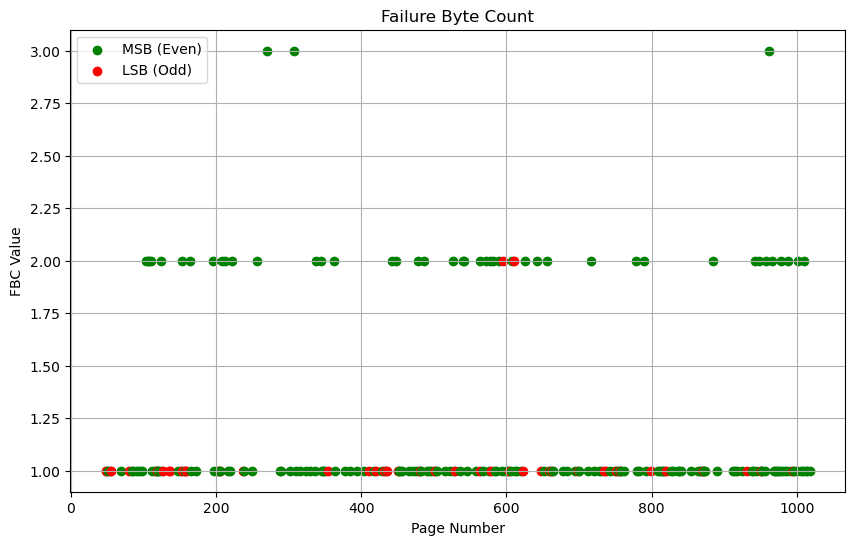

In [43]:
import matplotlib.pyplot as plt

fbc1_pages = [48, 49, 52, 54, 55, 70, 81, 84, 86, 92, 94, 98, 112, 116, 118, 119, 120, 122, 126, 127, 
              135, 137, 148, 152, 153, 157, 158, 159, 166, 172, 198, 202, 204, 205, 206, 216, 220, 
              237, 238, 250, 288, 290, 302, 310, 316, 324, 330, 336, 346, 348, 350, 355, 364, 378, 
              384, 394, 404, 411, 418, 421, 428, 431, 434, 435, 451, 452, 454, 456, 466, 472, 476, 
              480, 481, 482, 490, 494, 496, 500, 501, 504, 516, 522, 528, 529, 536, 546, 558, 563, 
              568, 576, 579, 584, 586, 594, 600, 602, 603, 606, 612, 614, 620, 623, 647, 652, 659, 
              660, 663, 664, 678, 684, 694, 699, 700, 712, 720, 728, 730, 735, 737, 742, 750, 751, 
              754, 756, 757, 758, 762, 780, 782, 792, 799, 808, 812, 814, 816, 818, 819, 826, 830, 
              836, 838, 840, 854, 864, 866, 868, 870, 871, 872, 874, 890, 912, 914, 918, 924, 931, 
              938, 940, 944, 950, 951, 952, 956, 968, 970, 972, 974, 976, 980, 984, 986, 992, 995, 
              996, 1000, 1006, 1008, 1012, 1014, 1018]
fbc2_pages = [104, 106, 108, 110, 124, 154, 164, 196, 208, 212, 222, 256, 338, 344, 362, 442, 448, 
              478, 486, 526, 540, 542, 564, 572, 578, 582, 590, 595, 608, 611, 626, 642, 656, 716, 
              778, 790, 884, 942, 948, 958, 966, 978, 988, 1002, 1010]
fbc3_pages = [270, 308, 962]
fbc4_pages = []

# Dictionary of FBC -> [page indices]
fbc_dict = {
    1: fbc1_pages,
    2: fbc2_pages,
    3: fbc3_pages,
    4: fbc4_pages,
}

plt.figure(figsize=(10, 6))

# Plot each page with the corresponding FBC
for fbc_value, pages in fbc_dict.items():
    for page in pages:
        # Even page => cross marker (x), Odd page => circle (o)
        marker_style = 'o' if page % 2 == 0 else 'o'
        color = 'green' if page % 2 == 0 else 'red'
        plt.scatter(page, fbc_value, c=color, marker=marker_style)

# Create invisible points just for the legend
#   - MSB (Even) => green 'x'
#   - LSB (Odd)  => red 'o'
plt.scatter([], [], c='green', marker='o', label='MSB (Even)')
plt.scatter([], [], c='red', marker='o', label='LSB (Odd)')

plt.legend()
plt.title("Failure Byte Count")
plt.xlabel("Page Number")
plt.ylabel("FBC Value")
plt.grid(True)

# Save the figure with high resolution (e.g., 300 dpi)
plt.savefig("Failure Byte Count.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [46]:
def count_failing_bits_in_page(page_data):
    """
    Given a list of bytes (page_data), count the total number of bits that are 1.
    """
    failing_bits = 0
    for byte_val in page_data:
        # Convert to binary string, then count how many '1' bits appear
        failing_bits += bin(byte_val).count('1')
    return failing_bits

In [45]:
def count_fbc(start_page, end_page, byte_to_write, fd):
    """
    Count the Failed Bit Count (FBC) from start_page to end_page
    and write the results to the provided file descriptor (fd).
    """

    page_per_block = 1024
    current_block = start_page // page_per_block
    fd.write(f"Block = {current_block}\n")
    pageFBC1 = []
    pageFBC2 = []
    pageFBC3 = []
    pageFBC4 = []

    block_fbc_count = 0
    page_data = bytes()
    # Read each page in the specified range
    for page_index in range(start_page, end_page):
        # Read data for the current page
        page_data = nand_read_full_page(page_index, current_block)
        
        # Count non-zero bytes
        page_fbc_count = count_failing_bits_in_page(page_data)
        if (page_fbc_count == 1):
            pageFBC1 += [ page_index ]
        elif (page_fbc_count == 2):
            pageFBC2 += [ page_index ]
        elif (page_fbc_count == 3):
            pageFBC3 += [ page_index ]
        elif (page_fbc_count == 4):
            pageFBC3 += [ page_index ]

        # Write page-level FBC and raw data
        fd.write(f"Page = {page_index}, FBC = {page_fbc_count}, ")
        fd.write(",".join(str(b) for b in page_data))
        fd.write("\n")

        block_fbc_count += page_fbc_count

        # Check if we've crossed into a new block
        new_block = page_index // page_per_block
        if new_block != current_block:
            # Reset for the new block
            block_fbc_count = page_fbc_count
            current_block = new_block
    #print(len(page_data))
    #print(page_data)
    print("FBC Process Completed")
    print ("FBC1:", end=" ")
    print (pageFBC1)
    print ("FBC2:", end=" ")
    print (pageFBC2)
    print ("FBC3:", end=" ")
    print (pageFBC3)
    print ("FBC4:", end=" ")
    print (pageFBC4)

In [47]:
# Specify your desired start and end pages
start_page = 0
end_page = 1024

# This is just a dummy value for 'byte_to_write'—you can set this as needed
byte_to_write = 0

# Open a file for logging
with open("CHECK_FBC_BITS_MLC_1.txt", "w") as fd:
    # Call the method, passing in your parameters and file descriptor
    count_fbc(start_page, end_page, byte_to_write, fd)

print("Done. Check 'CHECK_FBC_BITS_MLC_1.txt' for results.")

FBC Process Completed
FBC1: [48, 49, 52, 54, 55, 66, 70, 80, 86, 96, 110, 116, 120, 124, 126, 130, 136, 137, 142, 144, 145, 148, 153, 154, 157, 172, 178, 184, 190, 194, 196, 198, 200, 202, 208, 212, 216, 218, 220, 222, 230, 232, 237, 250, 256, 272, 280, 302, 308, 310, 314, 316, 334, 344, 348, 350, 355, 364, 370, 388, 394, 404, 406, 411, 418, 421, 431, 432, 434, 435, 436, 442, 446, 448, 451, 452, 454, 456, 460, 466, 472, 481, 482, 490, 498, 500, 501, 518, 522, 526, 532, 540, 542, 546, 568, 578, 579, 588, 600, 603, 604, 606, 611, 612, 620, 628, 632, 636, 642, 644, 656, 658, 663, 666, 668, 670, 684, 690, 694, 699, 700, 703, 704, 712, 720, 724, 728, 730, 735, 742, 748, 756, 757, 758, 762, 770, 778, 782, 792, 796, 807, 808, 814, 816, 818, 819, 824, 825, 826, 830, 840, 854, 864, 866, 870, 872, 874, 878, 886, 890, 892, 894, 912, 924, 926, 931, 935, 936, 942, 944, 945, 951, 952, 954, 956, 970, 972, 976, 980, 982, 988, 990, 995, 996, 1000, 1010, 1014, 1016]
FBC2: [74, 98, 104, 106, 112, 114, 12

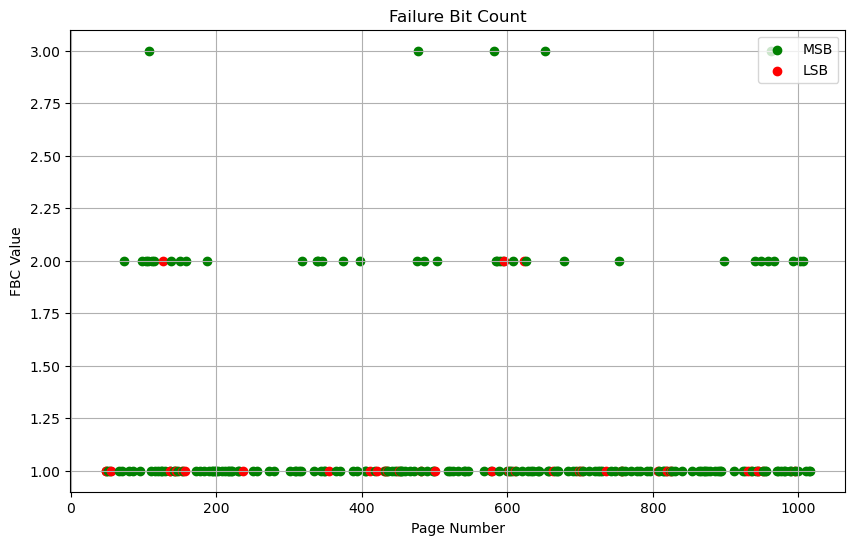

In [49]:
import matplotlib.pyplot as plt

fbc1_pages = [48, 49, 52, 54, 55, 66, 70, 80, 86, 96, 110, 116, 120, 124, 126, 130, 
              136, 137, 142, 144, 145, 148, 153, 154, 157, 172, 178, 184, 190, 194, 
              196, 198, 200, 202, 208, 212, 216, 218, 220, 222, 230, 232, 237, 250, 
              256, 272, 280, 302, 308, 310, 314, 316, 334, 344, 348, 350, 355, 364, 
              370, 388, 394, 404, 406, 411, 418, 421, 431, 432, 434, 435, 436, 442, 
              446, 448, 451, 452, 454, 456, 460, 466, 472, 481, 482, 490, 498, 500, 
              501, 518, 522, 526, 532, 540, 542, 546, 568, 578, 579, 588, 600, 603, 
              604, 606, 611, 612, 620, 628, 632, 636, 642, 644, 656, 658, 663, 666, 
              668, 670, 684, 690, 694, 699, 700, 703, 704, 712, 720, 724, 728, 730, 
              735, 742, 748, 756, 757, 758, 762, 770, 778, 782, 792, 796, 807, 808, 
              814, 816, 818, 819, 824, 825, 826, 830, 840, 854, 864, 866, 870, 872, 
              874, 878, 886, 890, 892, 894, 912, 924, 926, 931, 935, 936, 942, 944, 
              945, 951, 952, 954, 956, 970, 972, 976, 980, 982, 988, 990, 995, 996, 
              1000, 1010, 1014, 1016]

fbc2_pages = [74, 98, 104, 106, 112, 114, 127, 138, 150, 158, 188, 318, 338, 340, 
              346, 374, 398, 476, 486, 504, 584, 586, 590, 594, 595,608, 623, 626, 
              678, 754, 898, 940, 948, 958, 966, 992, 1002, 1006]
fbc3_pages = [108, 478, 582, 652, 962]
fbc4_pages = []

# Dictionary of FBC -> [page indices]
fbc_dict = {
    1: fbc1_pages,
    2: fbc2_pages,
    3: fbc3_pages,
    4: fbc4_pages,
}

plt.figure(figsize=(10, 6))

# Plot each page with the corresponding FBC
for fbc_value, pages in fbc_dict.items():
    for page in pages:
        # Even page => cross marker (x), Odd page => circle (o)
        marker_style = 'o' if page % 2 == 0 else 'o'
        color = 'green' if page % 2 == 0 else 'red'
        plt.scatter(page, fbc_value, c=color, marker=marker_style)

# Create invisible points just for the legend
#   - MSB (Even) => green 'x'
#   - LSB (Odd)  => red 'o'
plt.scatter([], [], c='green', marker='o', label='MSB')
plt.scatter([], [], c='red', marker='o', label='LSB')

plt.legend()
plt.title("Failure Bit Count")
plt.xlabel("Page Number")
plt.ylabel("FBC Value")
plt.grid(True)

# Save the figure with high resolution (e.g., 300 dpi)
plt.savefig("failure bit count.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()